
# Create Hippocampus sub-ROIs (full, anterior, posterior hippocampus)

- this notebook creates the MNI space hippo stuff

- this notebook gathers the indeces of the flattened hippo ROI and splits it into full, anterior and posterior hippocampus for later analyses.

In [1]:
import sys

## 1. Preprocess Hippocampus (remove nuisance regressors, etc)

In [3]:
#import dependencies
from tqdm import tqdm_notebook
from _mempal_util import create_dirs, session_tasks, fmriprep_dir
import nibabel as nib
import numpy as np
import os
import h5py
from sklearn import linear_model
from scipy import stats,special
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker #how is this diff from apply_mask?
from nilearn.masking import apply_mask #how is this different from niftimasker

##############
############## Input Arguments
########################################################

# fid = int(os.environ.get('SLURM_ARRAY_TASK_ID'))
# fid = 1

##############
############## DIRECTORY INFO
########################################################

# REPLACE WITH YOUR LOCATION OF FMRIPREPed DATA
fmriprep_dir = '/jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep'


##############
############## create all folders and fnames
########################################################

### create subj_prefix list
subj_prefix = [('sub-sid{:0>2d}'.format(i)) for i in np.arange(1, 29+1)]
nSubj = len(subj_prefix)

subj_sesh_dir = []
for subj in subj_prefix:
    subj_sesh_dir.append(subj + '/ses-01/func/')
    subj_sesh_dir.append(subj + '/ses-02/func/')
        
#create 
run_names = []
for subjIdx, subj in enumerate(subj_prefix):
    for task in session_tasks:
        run_names.append(subj + '_' + task)
        
fnames_preproc = []
fnames_mask = []
confnames = []
for subjIdx, subj in enumerate(subj_prefix):
    for seshIdx, sesh in enumerate(session_tasks):
        confnames.append(os.path.join(subj, sesh.split('_')[0], 'func', subj + '_' + sesh + '_bold_confounds.tsv'))
        fnames_preproc.append(os.path.join(subj, sesh.split('_')[0], 'func', subj + '_' + sesh + '_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'))
        fnames_mask.append(os.path.join(subj, sesh.split('_')[0], 'func', subj + '_' + sesh + '_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'))
        
        
# tasks = ['PV1', 'R1', 'R2', 'PV2', 'Recall', 'RO1', 'RO2']
tasks_rep = session_tasks * nSubj #tasks * num_subj 
subj_indeces = np.sort(list(np.arange(0,nSubj))*len(session_tasks))
                 
                 
##############
##############
########################################################

# os.getcwd()
# os.chdir('../')
# os.getcwd()

##############
############## MASK stuff
########################################################
     
masks_path = '../PythonData2024/Masks' #'/jukebox/norman/rmasis/MemPal/analysis/PythonData/masks'

hippo = {}
hippo['L'] = nib.load(os.path.join(masks_path,'30_hippo_Left_mask.nii.gz')).get_data()
hippo['R'] = nib.load(os.path.join(masks_path,'30_hippo_Right_mask.nii.gz')).get_data()

mask = np.logical_or(hippo['L'],hippo['R'])
mask_name = 'hippo'
# mask = mask.reshape((97*115*97)) #flatten

##############
############## 
########################################################   

processed_dir = '../PythonData2024/ProcessedData/' ; create_dirs(processed_dir)

regs = [] #accumulated regs
regrs = [] #accumulated...
errors=[]

D = dict()

for fid in tqdm_notebook(range(len(fnames_preproc))[:]):
    for preprocf,maskf,conf,run,task in zip([fnames_preproc[fid]], [fnames_mask[fid]], [confnames[fid]],[run_names[fid]], [tasks_rep[fid]]):


        try:

            print('***{}***'.format(run.split('_')[0]))

            print('    Processing run ', preprocf.split('/')[-1])

        #     if 'L.func.gii' in file:
        #         hem = 'L'
        #     elif 'R.func.gii' in file:
        #         hem = 'R'

            print('    Loading ', os.path.join(fmriprep_dir, preprocf))
            ni = nib.load(os.path.join(fmriprep_dir, preprocf))
        #     mask = nib.load(os.path.join(fmriprep_dir, maskf))

            print('nii shape: ', ni.shape)
            #print('mask shape: ', mask.shape)

            ##### MASKING ######
            #nifti_masker = NiftiMasker(mask_img=mask)
            #epi_mask_data = nifti_masker.fit_transform(ni)

            ##OR
            #epi_mask_data = apply_mask(ni, mask)

            ##OR if numpy 4d array
        #     print('    M[{}].shape: '.format(task), M[task].shape)

            epi_mask_data = ni.get_data()[mask] #[M[task]]


            print('   epi_mask_data shape: ', np.shape(epi_mask_data))


            # Use regressors for:
            # -CSF
            # -WhiteMatter
            # -FramewiseDisplacement
            # -All cosine bases for drift (0.008 Hz = 125s)
            # -X, Y, Z and derivatives
            # -RotX, RotY, RotZ and derivatives

            #confounds
            print('    Extracting confound information from ', conf)
            conf = np.genfromtxt(os.path.join(fmriprep_dir,conf), names=True)

            #motion correction needs to occur on all 3d axeses
            motion = np.column_stack((conf['X'],
              conf['Y'],
              conf['Z'],
              conf['RotX'],
              conf['RotY'],
              conf['RotZ']))


            #regressors list
            reg = np.column_stack((conf['CSF'],
                   conf['WhiteMatter'],
                   np.nan_to_num(conf['FramewiseDisplacement']),
                   np.column_stack([conf[k] for k in conf.dtype.names if 'Cosine' in k]),
                   motion,
                   np.vstack((np.zeros((1,motion.shape[1])), np.diff(motion, axis=0)))))

    #         regs.append(reg)

            #create linear regression object
            regr = linear_model.LinearRegression()

    #         regrs.append(regr)

            #train with regressors
            #reg : 595x26 ; D[hem] : 40962x595 ; D[hem].T : 595x40962 where 595 = n_samples, 26=n_features/explanatory, 40962=n_targets
            #reg : 595x26 ; epi_mask_data : 
            regr.fit(reg, epi_mask_data.T) 

        #     #use coeffs generated from fit
        #     print('   epi_mask_data shape: ', np.shape(epi_mask_data))
        #     print('   np dot regrcoef, reg.t shape: ', np.shape(np.dot(regr.coef_, reg.T)) )
        #     print('   interecept shape: ', np.shape(regr.intercept_[:, np.newaxis]))

            #subtract the nuissance regressors from the data (https://www.sciencedirect.com/science/article/pii/S1053811916307418)
            #D[hem] = D[hem] - np.dot(regr.coef_, reg.T) - regr.intercept_[:, np.newaxis]
            epi_mask_data = epi_mask_data - np.dot(regr.coef_, reg.T) - regr.intercept_[:,np.newaxis]

            #z-score (center the data) across the timeseries dimension;
            epi_mask_data = stats.zscore(epi_mask_data, axis=1) #epi_mask_data is now back to OG shape

            subj = preprocf.split('/')[0]

            with h5py.File(os.path.join(processed_dir,subj, run + '_MNI152_{}'.format(mask_name) +'.h5'), 'w') as hf:
                hf.create_dataset('MNI', data=epi_mask_data)

        except Exception as e: 
            print('**** ERROR ****')
            print('**** ERROR ****')
            print('---something happened---')
            print(e)
            errors.append(e)
            print('**** ERROR ****')
            print('**** ERROR ****')


    ############## 
    ##############  Print out a log of errors, which subjects went bad?
    ########################################################  

    log_dir = '../PythonData2024/Logs'
    
    ## create dir called ProcessedData if not already existing
    create_dirs(log_dir) 

    with open(os.path.join(log_dir,"id{:03d}_mni_log.txt".format(fid)), "w") as output:
        output.write(str(errors))

    print('Finished cleaning and preprocessing each run EPI.')  


Folder already exists: ../PythonData2024/ProcessedData/


/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/203 [00:00<?, ?it/s]

***sub-sid01***
    Processing run  sub-sid01_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid01/ses-01/func/sub-sid01_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid01/ses-01/func/sub-sid01_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid01***
    Processing run  sub-sid01_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid01/ses-01/func/sub-sid01_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 235)
   epi_mask_data shape:  (1668, 23

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid02/ses-02/func/sub-sid02_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid03***
    Processing run  sub-sid03_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid03/ses-01/func/sub-sid03_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid03/ses-01/func/sub-sid03_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid03***
    Processing run  sub-sid03_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid04/ses-02/func/sub-sid04_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid05***
    Processing run  sub-sid05_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid05/ses-01/func/sub-sid05_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid05/ses-01/func/sub-sid05_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid05***
    Processing run  sub-sid05_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid06/ses-02/func/sub-sid06_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid07***
    Processing run  sub-sid07_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid07/ses-01/func/sub-sid07_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid07/ses-01/func/sub-sid07_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid07***
    Processing run  sub-sid07_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid08/ses-02/func/sub-sid08_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid09***
    Processing run  sub-sid09_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid09/ses-01/func/sub-sid09_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid09/ses-01/func/sub-sid09_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid09***
    Processing run  sub-sid09_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid10/ses-02/func/sub-sid10_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid11***
    Processing run  sub-sid11_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid11/ses-01/func/sub-sid11_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid11/ses-01/func/sub-sid11_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid11***
    Processing run  sub-sid11_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid12/ses-02/func/sub-sid12_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid13***
    Processing run  sub-sid13_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid13/ses-01/func/sub-sid13_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid13/ses-01/func/sub-sid13_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid13***
    Processing run  sub-sid13_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid14/ses-02/func/sub-sid14_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid15***
    Processing run  sub-sid15_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid15/ses-01/func/sub-sid15_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid15/ses-01/func/sub-sid15_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid15***
    Processing run  sub-sid15_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid16/ses-02/func/sub-sid16_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid17***
    Processing run  sub-sid17_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid17/ses-01/func/sub-sid17_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid17/ses-01/func/sub-sid17_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid17***
    Processing run  sub-sid17_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid18/ses-02/func/sub-sid18_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid19***
    Processing run  sub-sid19_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid19/ses-01/func/sub-sid19_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid19/ses-01/func/sub-sid19_ses-01_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid19***
    Processing run  sub-sid19_ses-01_task-roomvideo_run-01_bold_space-MNI152NLin2009cAsym_pr

nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid20/ses-02/func/sub-sid20_ses-02_task-roomobjectvideo_run-02_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid21***
    Processing run  sub-sid21_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid21/ses-01/func/sub-sid21_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
**** ERROR ****
**** ERROR ****
---something happened---
No such file or no access: '/jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid21/ses-01/func/sub-sid21_ses-01_task-pathvideo_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
**** ERROR ****
**** ERROR ****
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preproc

nii shape:  (97, 115, 97, 1284)
   epi_mask_data shape:  (1668, 1284)
    Extracting confound information from  sub-sid22/ses-02/func/sub-sid22_ses-02_task-recall_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid22***
    Processing run  sub-sid22_ses-02_task-roomobjectvideo_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid22/ses-02/func/sub-sid22_ses-02_task-roomobjectvideo_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 460)
   epi_mask_data shape:  (1668, 460)
    Extracting confound information from  sub-sid22/ses-02/func/sub-sid22_ses-02_task-roomobjectvideo_run-01_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid22***
    Processing run  sub-sid22_ses-02_task-roomobjectvideo_run-02_bo

nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid24/ses-02/func/sub-sid24_ses-02_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid24***
    Processing run  sub-sid24_ses-02_task-recall_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid24/ses-02/func/sub-sid24_ses-02_task-recall_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 2154)
   epi_mask_data shape:  (1668, 2154)
    Extracting confound information from  sub-sid24/ses-02/func/sub-sid24_ses-02_task-recall_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid24***
    Processing run  sub-sid24_ses-02_task-roomobjectvideo_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
 

nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid26/ses-02/func/sub-sid26_ses-02_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid26***
    Processing run  sub-sid26_ses-02_task-recall_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid26/ses-02/func/sub-sid26_ses-02_task-recall_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 1701)
   epi_mask_data shape:  (1668, 1701)
    Extracting confound information from  sub-sid26/ses-02/func/sub-sid26_ses-02_task-recall_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid26***
    Processing run  sub-sid26_ses-02_task-roomobjectvideo_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
 

nii shape:  (97, 115, 97, 595)
   epi_mask_data shape:  (1668, 595)
    Extracting confound information from  sub-sid28/ses-02/func/sub-sid28_ses-02_task-pathvideo_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid28***
    Processing run  sub-sid28_ses-02_task-recall_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    Loading  /jukebox/norman/rmasis/MemPal/data/BIDS/Norman/Baldassano/10442_vrpalace/derivatives/fmriprep/sub-sid28/ses-02/func/sub-sid28_ses-02_task-recall_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
nii shape:  (97, 115, 97, 2678)
   epi_mask_data shape:  (1668, 2678)
    Extracting confound information from  sub-sid28/ses-02/func/sub-sid28_ses-02_task-recall_bold_confounds.tsv
Folder already exists: ../PythonData2024/Logs
Finished cleaning and preprocessing each run EPI.
***sub-sid28***
    Processing run  sub-sid28_ses-02_task-roomobjectvideo_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
 

## 2. Generate sub-ROIs files and save them if not already in ROI directory


In [1]:

#import dependencies
from _mempal_util import *
import numpy as np
import os
import h5py
from sklearn import linear_model
from scipy import stats,special
import nibabel as nib
from nibabel.affines import apply_affine
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker


/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
masks_path = '../PythonData2024/Masks'

hippo = {}
hippo['L'] = nib.load(os.path.join(masks_path,'30_hippo_Left_mask.nii.gz')).get_data()
hippo['R'] = nib.load(os.path.join(masks_path,'30_hippo_Right_mask.nii.gz')).get_data()

hippo_coords = np.transpose(np.nonzero(np.logical_or(hippo['L'],hippo['R'])))
print("shape of epi space: ", hippo_coords.shape)

epi_vox_center = (np.array(hippo['L'].shape) - 1) / 2.
print("center of epi space: ", epi_vox_center)

## y = 56 is where there is -20 in fslview, which matches with literature y > -20 for anterior hippo
print(np.where(hippo_coords[:,1] >= 56)[0].shape , np.where(hippo_coords[:,1] < 56)[0].shape)


### SAVE SAVE SAVE

roi_path ='../PythonData2024/ROIs'

## create dir called ROIs if not already existing
create_dirs(roi_path)

## if hippo verts already saved, then do nothing.
if not os.path.exists(os.path.join(roi_path,"hippo_verts.h5")):
    with h5py.File(os.path.join(roi_path,"hippo_verts.h5"), "w") as hf:  
        hf.create_dataset("hippo", data= np.arange(hippo_coords.shape[0]))
        hf.create_dataset("ahippo", data=np.where(hippo_coords[:,1]>=56)[0])
        hf.create_dataset("phippo", data=np.where(hippo_coords[:,1]<56)[0])
else:
    print("...hippo verts already created.")


shape of epi space:  (1668, 3)
center of epi space:  [48. 57. 48.]
(863,) (805,)


## Visualize Hippo coordinate space

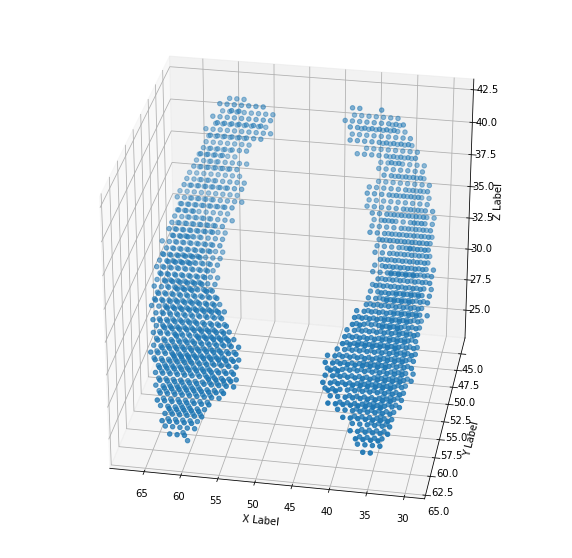

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline

### PLOT HIPPO ###

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hippo_coords[:,0],hippo_coords[:,1],hippo_coords[:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

angle = 100
ax.view_init(30, angle)
plt.draw()



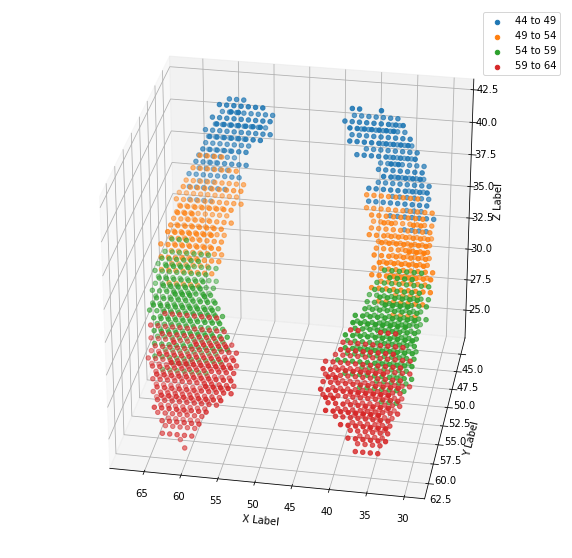

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(hippo_coords[:,0],hippo_coords[:,1],hippo_coords[:,2], c='y')

#intervals = np.linspace(0, hippo_coords.shape[0], 7).astype(int)
intervals = np.linspace(hippo_coords[:,1].min(),hippo_coords[:,1].max(),5).astype(int)

# colors = []
for i in range(len(intervals)-1): 
    index = np.where((hippo_coords[:,1]>=intervals[i]) & (hippo_coords[:,1]<intervals[i+1]))[0]
    ax.scatter(hippo_coords[index,0],hippo_coords[index,1],hippo_coords[index,2],label='{} to {}'.format(intervals[i],intervals[i+1]))


plt.legend()

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

angle = 100
ax.view_init(30, angle)
plt.draw()
